In [3]:
!pip install -r requirements.txt
!pip install -U ultralytics
!yolo checks


Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\owner\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Ultralytics 8.4.9  Python-3.12.7 torch-2.9.1+cpu CPU (12th Gen Intel Core i7-1255U)
Setup complete  (12 CPUs, 15.7 GB RAM, 440.8/474.7 GB disk)

OS                     Windows-11-10.0.26200-SP0
Environment            Windows
Python                 3.12.7
Install                pip
Path                   C:\Users\owner\anaconda3\Lib\site-packages\ultralytics
RAM                    15.73 GB
Disk                   440.8/474.7 GB
CPU                    12th Gen Intel Core i7-1255U
CPU count              12
GPU                    None
GPU count              None
CUDA                   None

numpy                   1.26.4>=1.23.0
matplotlib              3.10.8>=3.3.0
o

Converting COCO to YOLO

In [ ]:
import json
import random
from pathlib import Path
from PIL import Image

randomSeed = 42
random.seed(randomSeed)

allowedDetectionNames = [
    "Roadworks",
    "No Entry (One Way)",
    "Stop",
    "Pedestrian Crossing",
    "Roundabout Ahead",
    "No Through Road (T-sign)",
    "Blind-Spot Mirror (Convex)",
    "Animal",
    "Two Way",
    "No Stopping",
    "Parking",
    "Turn (left/right)",
    "Speed Limit",
    "Uneven Road",
    "No Turn (left/right)",
    "Maximum Height",
    "No U-turn",
    "Two-way traffic",
    "Road Narrows",
    "No Parking",
    "Traffic Light",
    "Give way",
    "Bump",
    "No Waiting",
    "Priority To/Over Oncoming Vehicles"
]

cocoDir = Path("signs_coco")
imagesDir = cocoDir / "images"
cocoJsonPath = cocoDir / "result.json"

outputDir = Path("datasets/yoloSigns")
labelsDir = outputDir / "labels"
splitDir = outputDir / "images"

for splitName in ["train", "val", "test"]:
    (labelsDir / splitName).mkdir(parents=True, exist_ok=True)
    (splitDir / splitName).mkdir(parents=True, exist_ok=True)

with open(cocoJsonPath, "r", encoding="utf-8") as f:
    coco = json.load(f)

imagesById = {img["id"]: img for img in coco["images"]}

annotationsByImageId = {}
for ann in coco["annotations"]:
    imageId = ann["image_id"]
    annotationsByImageId.setdefault(imageId, []).append(ann)

categoryIdToName = {cat["id"]: cat["name"] for cat in coco["categories"]}
allowedCategoryIds = {catId for catId, name in categoryIdToName.items() if name in allowedDetectionNames}

classNames = allowedDetectionNames[:]
nameToClassIndex = {name: i for i, name in enumerate(classNames)}

imageIds = list(imagesById.keys())
random.shuffle(imageIds)

n = len(imageIds)
trainEnd = int(0.8 * n)
valEnd = int(0.9 * n)

splits = {
    "train": imageIds[:trainEnd],
    "val": imageIds[trainEnd:valEnd],
    "test": imageIds[valEnd:]
}

def writeYoloLabel(labelPath, anns, imgW, imgH):
    lines = []
    for ann in anns:
        annCategoryId = ann["category_id"]
        if annCategoryId not in allowedCategoryIds:
            continue 

        className = categoryIdToName[annCategoryId]
        classIndex = nameToClassIndex[className]

        x, y, w, h = ann["bbox"] 

        xCenter = (x + w / 2) / imgW
        yCenter = (y + h / 2) / imgH
        wNorm = w / imgW
        hNorm = h / imgH

        lines.append(f"{classIndex} {xCenter:.6f} {yCenter:.6f} {wNorm:.6f} {hNorm:.6f}")

    labelPath.write_text("\n".join(lines), encoding="utf-8")

for splitName, splitImageIds in splits.items():
    for imageId in splitImageIds:
        imgInfo = imagesById[imageId]

        fileName = imgInfo["file_name"]
        imageFileName = Path(fileName).name
        srcImagePath = imagesDir / imageFileName

        with Image.open(srcImagePath) as im:
            imgW, imgH = im.size

        dstImagePath = splitDir / splitName / imageFileName
        dstImagePath.write_bytes(srcImagePath.read_bytes())

        labelPath = labelsDir / splitName / (Path(imageFileName).stem + ".txt")
        anns = annotationsByImageId.get(imageId, [])
        writeYoloLabel(labelPath, anns, imgW, imgH)

print("Done.")
print("YOLO Classes (detection only):", classNames)
print({k: len(v) for k, v in splits.items()})


Done.
YOLO Classes (detection only): ['Roadworks', 'No Entry (One Way)', 'Stop', 'Pedestrian Crossing', 'Roundabout Ahead', 'No Through Road (T-sign)', 'Blind-Spot Mirror (Convex)', 'Animal', 'Two Way', 'No Stopping', 'Parking', 'Turn (left/right)', 'Speed Limit', 'Uneven Road', 'No Turn (left/right)', 'Maximum Height', 'No U-turn', 'Two-way traffic', 'Road Narrows', 'No Parking', 'Traffic Light', 'Give way', 'Bump', 'No Waiting', 'Priority To/Over Oncoming Vehicles']
{'train': 481, 'val': 60, 'test': 61}


In [20]:
from pathlib import Path
import yaml

outputDir = Path("datasets/yoloSigns")
dataYamlPath = outputDir / "data.yaml"

data = {
    "path": str(outputDir.resolve()),
    "train": "images/train",
    "val": "images/val",
    "test": "images/test",
    "names": [
        "Roadworks",
        "No Entry (One Way)",
        "Stop",
        "Pedestrian Crossing",
        "Roundabout Ahead",
        "No Through Road (T-sign)",
        "Blind-Spot Mirror (Convex)",
        "Animal",
        "Two Way",
        "No Stopping",
        "Parking",
        "Turn (left/right)",
        "Speed Limit",
        "Uneven Road",
        "No Turn (left/right)",
        "Maximum Height",
        "No U-turn",
        "Two-way traffic",
        "Road Narrows",
        "No Parking",
        "Traffic Light",
        "Give way",
        "Bump",
        "No Waiting",
        "Priority To/Over Oncoming Vehicles"
    ]
}

dataYamlPath.write_text(yaml.safe_dump(data, sort_keys=False), encoding="utf-8")
print(dataYamlPath.read_text())


path: C:\Users\owner\Desktop\ARI3129-SignDetectors-Classifiers\datasets\yoloSigns
train: images/train
val: images/val
test: images/test
names:
- Roadworks
- No Entry (One Way)
- Stop
- Pedestrian Crossing
- Roundabout Ahead
- No Through Road (T-sign)
- Blind-Spot Mirror (Convex)
- Animal
- Two Way
- No Stopping
- Parking
- Turn (left/right)
- Speed Limit
- Uneven Road
- No Turn (left/right)
- Maximum Height
- No U-turn
- Two-way traffic
- Road Narrows
- No Parking
- Traffic Light
- Give way
- Bump
- No Waiting
- Priority To/Over Oncoming Vehicles



In [ ]:
from pathlib import Path

labelsTrainDir = Path("datasets/yoloSigns/labels/train")
badLines = 0

for txtPath in labelsTrainDir.glob("*.txt"):
    content = txtPath.read_text(encoding="utf-8").strip()
    if content == "":
        continue
    for line in content.splitlines():
        parts = line.split()
        if len(parts) != 5:
            badLines += 1
            continue
        _, x, y, w, h = parts
        x, y, w, h = map(float, [x, y, w, h])
        if not (0 <= x <= 1 and 0 <= y <= 1 and 0 <= w <= 1 and 0 <= h <= 1):
            badLines += 1

print("Bad lines found:", badLines)


Empty label files: 0
Bad lines found: 4


In [21]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")  # nano baseline

results = model.train(
    data="datasets/yoloSigns/data.yaml",
    epochs=50,
    imgsz=640,
    batch=8,
    device="cpu",
    project="runs/yolov11",
    name="signs_yolo11n_detOnly",
    patience=10,
    save=True
)


Ultralytics 8.4.9  Python-3.12.7 torch-2.9.1+cpu CPU (12th Gen Intel Core i7-1255U)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/yoloSigns/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=signs_yolo11n_detOnly, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10

In [26]:
from ultralytics import YOLO

bestWeights = r"runs/detect/runs/yolov11/signs_yolo11n_detOnly/weights/best.pt"
model = YOLO(bestWeights)

metrics = model.val(data="datasets/yoloSigns/data.yaml")
print(metrics)


Ultralytics 8.4.9  Python-3.12.7 torch-2.9.1+cpu CPU (12th Gen Intel Core i7-1255U)
YOLO11n summary (fused): 101 layers, 2,587,027 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1719.4296.1 MB/s, size: 2364.7 KB)
val: Scanning C:\Users\owner\Desktop\ARI3129-SignDetectors-Classifiers\datasets\yoloSigns\labels\val.cache... 60 images, 0 backgrounds, 3 corrupt: 100% ━━━━━━━━━━━━ 60/60  0.0s
val: C:\Users\owner\Desktop\ARI3129-SignDetectors-Classifiers\datasets\yoloSigns\images\val\2f1ba9d0-IMG_6375.jpeg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.298]
val: C:\Users\owner\Desktop\ARI3129-SignDetectors-Classifiers\datasets\yoloSigns\images\val\375c3017-Pre_2026_6668.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.029]
val: C:\Users\owner\Desktop\ARI3129-SignDetectors-Classifiers\datasets\yoloSigns\images\val\cb5bea14-IMG_6410.jpeg: ignoring corrupt image/label: non-normalized 

In [27]:
from pathlib import Path

testImages = list(Path("datasets/yoloSigns/images/test").glob("*"))[:12]
model.predict(
    source=[str(p) for p in testImages],
    save=True,
    project="runs/yolov11",
    name="pred_detOnly"
)



0: 640x640 1 Roundabout Ahead, 1 Give way, 61.0ms
1: 640x640 1 Roundabout Ahead, 61.0ms
2: 640x640 1 No Entry (One Way), 61.0ms
3: 640x640 1 No Entry (One Way), 61.0ms
4: 640x640 (no detections), 61.0ms
5: 640x640 1 Uneven Road, 61.0ms
6: 640x640 1 Blind-Spot Mirror (Convex), 61.0ms
7: 640x640 1 Speed Limit, 61.0ms
8: 640x640 1 Roundabout Ahead, 1 Turn (left/right), 61.0ms
9: 640x640 (no detections), 61.0ms
10: 640x640 1 Stop, 61.0ms
11: 640x640 1 No Entry (One Way), 61.0ms
Speed: 3.1ms preprocess, 61.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to C:\Users\owner\Desktop\ARI3129-SignDetectors-Classifiers\runs\detect\runs\yolov11\pred_detOnly


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Roadworks', 1: 'No Entry (One Way)', 2: 'Stop', 3: 'Pedestrian Crossing', 4: 'Roundabout Ahead', 5: 'No Through Road (T-sign)', 6: 'Blind-Spot Mirror (Convex)', 7: 'Animal', 8: 'Two Way', 9: 'No Stopping', 10: 'Parking', 11: 'Turn (left/right)', 12: 'Speed Limit', 13: 'Uneven Road', 14: 'No Turn (left/right)', 15: 'Maximum Height', 16: 'No U-turn', 17: 'Two-way traffic', 18: 'Road Narrows', 19: 'No Parking', 20: 'Traffic Light', 21: 'Give way', 22: 'Bump', 23: 'No Waiting', 24: 'Priority To/Over Oncoming Vehicles'}
 obb: None
 orig_img: array([[[131,  72,  32],
         [137,  78,  38],
         [134,  75,  35],
         ...,
         [134,  75,  35],
         [135,  76,  36],
         [136,  77,  37]],
 
        [[129,  70,  30],
         [134,  75,  35],
         [132,  73,  33],
         ...,
         [137,  78,  38],
         [138,

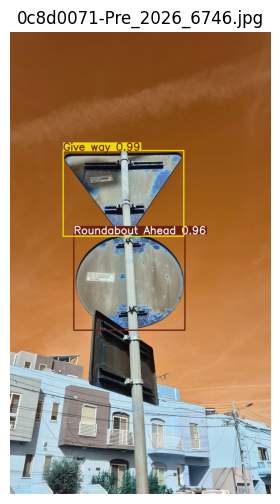

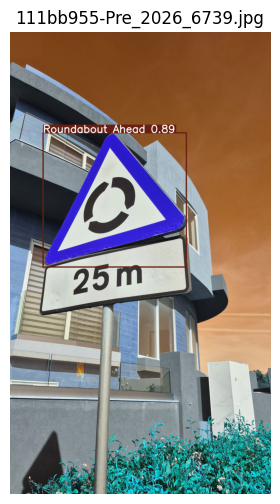

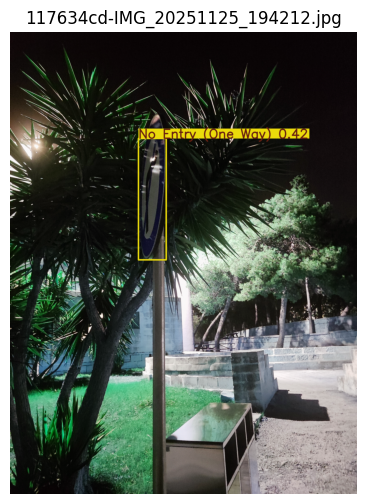

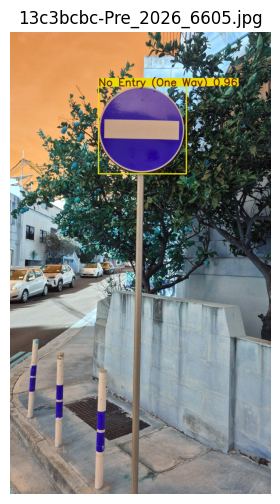

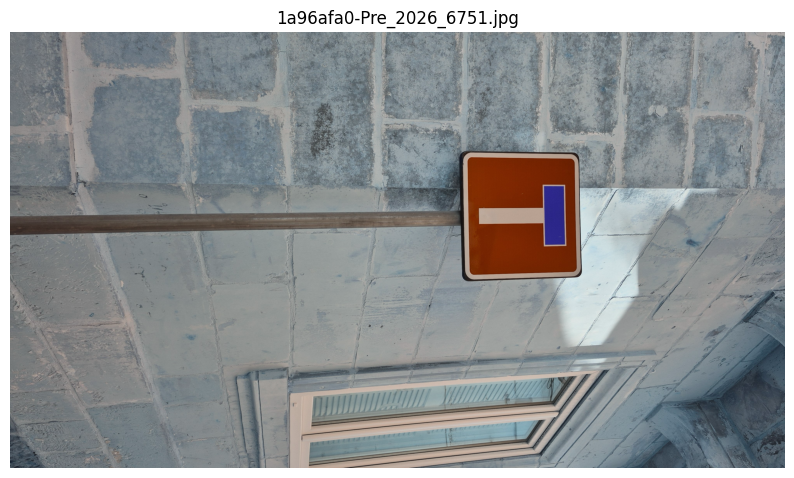

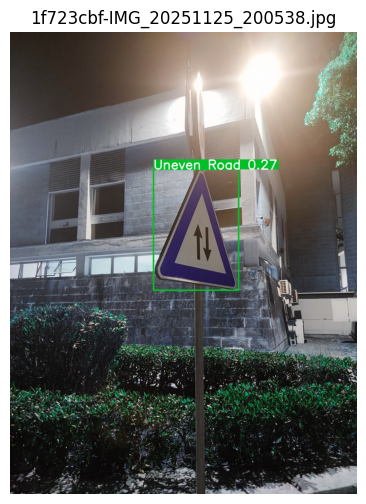

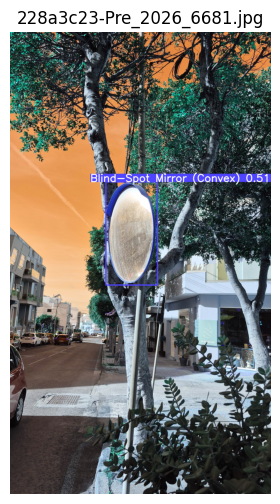

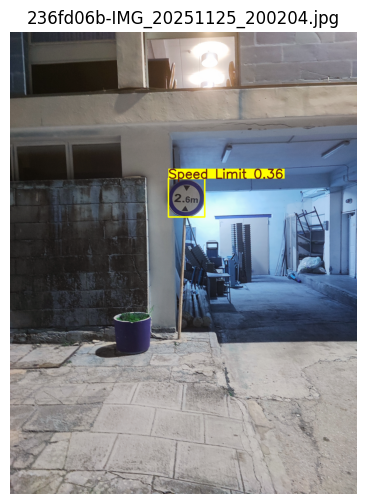

In [ ]:
%matplotlib inline
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt

bestWeights = r"runs/detect/runs/yolov11/signs_yolo11n_detOnly/weights/best.pt"
model = YOLO(bestWeights)

testImages = list(Path("datasets/yoloSigns/images/test").glob("*"))[:8]

results = model.predict(source=[str(p) for p in testImages], conf=0.25, verbose=False)

for r in results:
    annotated = r.plot() 
    plt.figure(figsize=(10, 6))
    plt.imshow(annotated)
    plt.axis("off")
    plt.title(Path(r.path).name)
    plt.show()
